# Preamplificatore Di Carica

**TODO**
1. Simulazione esponenziale
2. Errori sulle t nell'esponenziale+lineare
3. Errori sulle tensioni nel lineare
4. Stima frequenza di taglio da bode

## Importo librerie python

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import math

Riporto anche alcune costanti utili per tutto il notebook

In [4]:
# distribuzione uniforme
deltaTosigma= 0.58
# multimetro 
multi_C_dig = 5*deltaTosigma # errore digit capacità
multi_C_k = 0.03*deltaTosigma # errore scala capacità

multi_R_dig = 2*deltaTosigma # errore digit resistenza
multi_R_k = 0.008*deltaTosigma # errore scala resistenza

# oscilloscopio (tensioni)
osc_scala = 0.03*deltaTosigma
osc_dig = 2/256*deltaTosigma

# oscilloscopio (tempi)
# trascurabile?
osc_t_err=0.04 # errore lettura, [div]
print(osc_dig)

0.00453125


## Misure dirette dei componenti 

In [4]:
# capacità
Cf_pre = 0.189 # nF
Cf_pre_err=((0.001*multi_C_dig)**2 
           + (Cf_pre*multi_C_k)**2)**0.5

# resistenze
Rf_pre = 0.816 # MOhm
Rf_pre_err=((0.001*multi_R_dig)**2 
           + (Rf_pre*multi_R_k)**2)**0.5
Rin = 82.0 #kOhm
Rin_err = ((0.1*multi_R_dig)**2+
          (Rin*multi_R_k)**2)**0.5
# generatore
Rgen = 600 # Ohm
#Rin=Rin+Rgen*10**(-3)
print("Cf_pre (nF)", Cf_pre, Cf_pre_err,Cf_pre_err/Cf_pre*100)
print("Rf_pre (MOhm)", Rf_pre, Rf_pre_err, Rf_pre_err/Rf_pre*100)
print("Rin (kOhm)", Rin, Rin_err, Rin_err/Rin*100)

Cf_pre (nF) 0.189 0.004384619705288019 2.319904605972497
Rf_pre (MOhm) 0.816 0.003959951178688949 0.48528813464325354
Rin (kOhm) 82.0 0.397770072277943 0.4850854539974915


Stimo il tempo caratteristico atteso

In [5]:
tau_pre = Rf_pre * Cf_pre # ms
tau_pre_err=((Cf_pre*Rf_pre_err)**2+
             (Rf_pre*Cf_pre_err)**2)**0.5
print("tau_pre (ms)", tau_pre, tau_pre_err, tau_pre_err/tau_pre*100)
print("ft teo (kHz)", 1/(2*math.pi*tau_pre), tau_pre_err/(2*math.pi*tau_pre**2))

tau_pre (ms) 0.154224 0.0036552916369064405 2.3701185528234516
ft teo (kHz) 1.03197260537851 0.024458974180131616


Stimo la tensione massima attesa, se in input metto un'onda quadra di periodo $5\,us$ e ampiezza $-1V$.

In [6]:
Vmax_th = 1*5/(Rin) / Cf_pre # mV
Vmax_th_e= Vmax_th*((Rin_err/Rin)**2+(Cf_pre_err/Cf_pre)**2+(5*3/100 *1/5)**2)**0.5
print("Vmax_th (V)", Vmax_th, Vmax_th_e, Vmax_th_e/Vmax_th*100)

Vmax_th (V) 0.32262227384178604 0.01233466651286021 3.8232532323261506


Sperimentalmente invece osservo una tensione massima 

In [7]:
Vmax_sp=0.3439 # mV
Vmax_sp_scala=0.5
Vmax_sp_err= ((Vmax_sp*osc_scala)**2+(Vmax_sp_scala*osc_dig)**2)**0.5
print(Vmax_sp,Vmax_sp_err, Vmax_sp_err/Vmax_sp*100)

0.3439 0.006398408953812267 1.8605434585089466


## Verifica della linearità

Carico i dati contententi il periodo dell'onda in igresso e la corrispondente tensione di uscita massima.

In [8]:
preamp_lin = pd.read_csv("dati/preamp_lin.txt", delimiter="\t")
# freq Hz
# voult Volt
preamp_lin

,freq,vout,scala
0,1000,0.3439,0.5
1,800,0.4273,0.5
2,700,0.4627,0.5
3,600,0.5436,1.0
4,500,0.6220,1.0
5,400,0.7813,1.0
6,350,0.8647,2.0


Calcolo il periodo dell'onda quadra in ingresso (99.5% della frequenza impostata) e la quantità di carica che attraverso il condensatore.

In [9]:
vin=0.998 # Volt
vin_scala=2
vin_err = ((vin*osc_scala)**2+
           (vin_scala*osc_dig)**2)**0.5
preamp_lin['T']=1/preamp_lin['freq']*0.005e6 # us
preamp_lin['Q']= vin/Rin*preamp_lin['T'] # nC

# errori (vedi slide)
preamp_lin['T_err']= preamp_lin['T']*0.03
preamp_lin['T_errK']= 0.03
preamp_lin['Q_err']= preamp_lin['Q']* ( (vin_err/vin)**2+
                                  (preamp_lin['T_errK'])**2+
                                  (Rin_err/Rin)**2)**0.5
preamp_lin

,freq,vout,scala,T,Q,T_err,T_errK,Q_err
0,1000,0.3439,0.5,5.000000,0.060854,0.150000,0.03,0.002201
1,800,0.4273,0.5,6.250000,0.076067,0.187500,0.03,0.002752
2,700,0.4627,0.5,7.142857,0.086934,0.214286,0.03,0.003145
3,600,0.5436,1.0,8.333333,0.101423,0.250000,0.03,0.003669
4,500,0.6220,1.0,10.000000,0.121707,0.300000,0.03,0.004403
5,400,0.7813,1.0,12.500000,0.152134,0.375000,0.03,0.005504
6,350,0.8647,2.0,14.285714,0.173868,0.428571,0.03,0.006290


Calcolo gli errori sulle tensioni di uscita (come differenza tra il valore di due cursori)

In [10]:
# provo a non mettere il fattore sqrt(2) 
preamp_lin['vout_err']=((preamp_lin['vout']*osc_scala)**2+
                       (preamp_lin['scala']*osc_dig)**2)**0.5
print("errori relativi vout")
preamp_lin['vout_err']

errori relativi vout


0    0.006398
1    0.007773
2    0.008364
3    0.010488
4    0.011733
5    0.014330
6    0.017564
Name: vout_err, dtype: float64

Mostro ora in grafico le coppie $Q_i$, $V_i$

<ErrorbarContainer object of 3 artists>

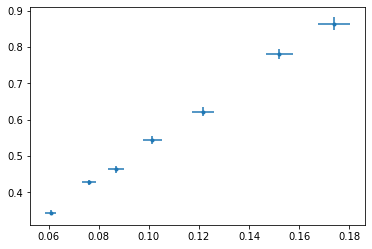

In [11]:
X=preamp_lin['Q']
Y=preamp_lin['vout']
errX=preamp_lin['Q_err']
errY=preamp_lin['vout_err']
plt.errorbar(X,Y,xerr=errX, yerr=errY,
            fmt='.')

Inizio con il fare un fit $V_{out}$ vs $T$, trascurando gli errori sulle ordinate, da cui ricavo il coefficente angolare $m_r=m/I$.  Correggo l'errore
con l'incertezza di scala sul periodo ($3\%$).
Faccio poi il fit $V_{out}$ vs $Q$ e aggiungo l'errore sulla corrente al coefficiente angolare in seguito.

b 0.05661540667762272 0.002209858256064348
m,q [4.65176688 0.06437297]
cov [[ 0.01349318 -0.00120122]
 [-0.00120122  0.00011948]]
sigmap 0.009129721662132623 chisq 3.877100932354036
comp chi sq/ndf 0.3550918636240733
comp q con zero 5.889227949634666
0.0643729660926475 0.010930629047333927


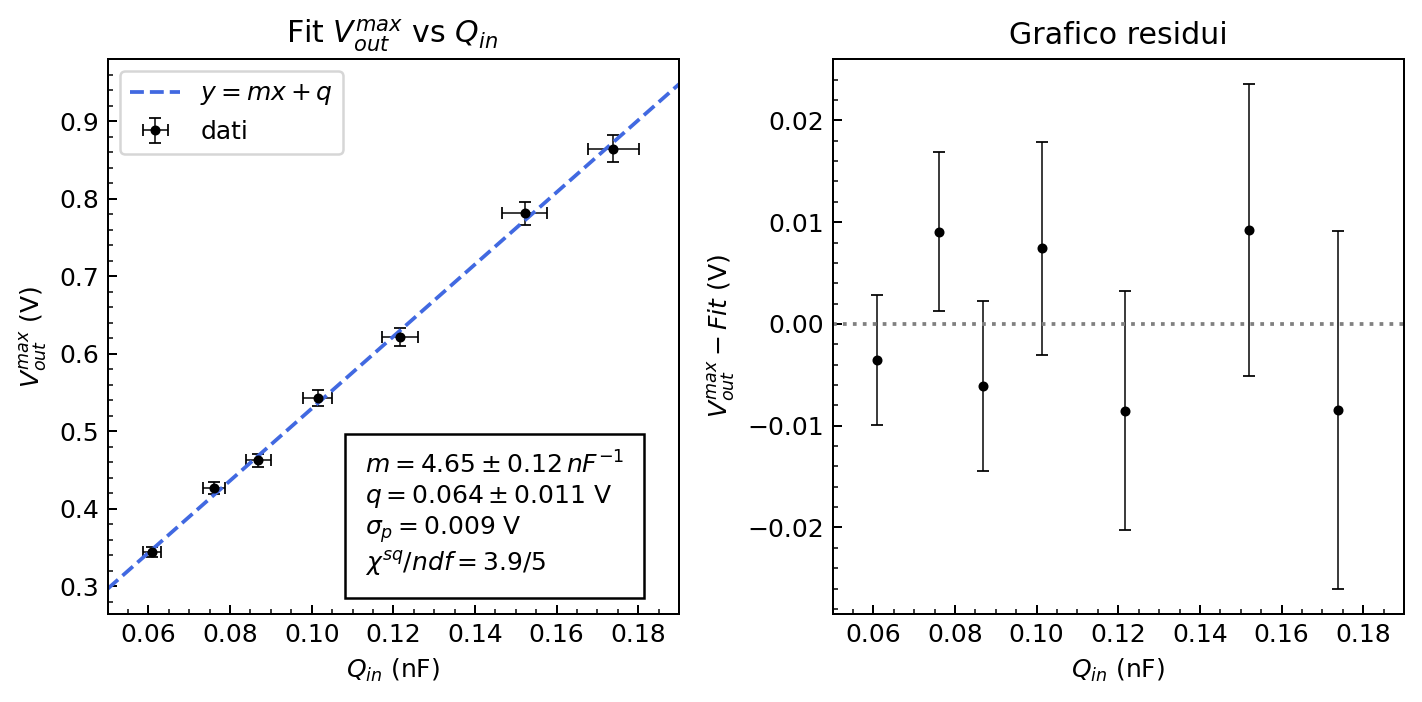

In [95]:
# dati sperimentali
X=preamp_lin['Q']
Xin=preamp_lin['T']
Y=preamp_lin['vout']
errX=preamp_lin['Q_err']
errY=preamp_lin['vout_err']

# limiti plot
xmin=0.05
xmax=0.19

# funzione interpolante
def linF(X,m,q):
    return X*m+q

# fit iniziale Vout vs T
par,cov=curve_fit(linF,Xin,Y,sigma=errY, absolute_sigma=True)
err_mr= (cov[0][0]+(par[0]*0.03)**2)**0.5
#err_mr = cov[0][0]**0.5
mr=par[0]
# fit definitivo Vout vs Q
par,cov=curve_fit(linF,X,Y,sigma=errY, absolute_sigma=True)


# residui
diff = Y-linF(X,*par)

# chisq e sigma post
sigmap = (np.sum(diff**2)/(len(diff)-2))**0.5
chisq = np.sum(diff**2/errY**2)

# creo plot  
fig,axes=plt.subplots(ncols=2, figsize=(8,4))
fig.set_dpi(180)


# plot dati
axes[0].errorbar(X,Y,xerr=errX, yerr=errY,
                 fmt='.', color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)

# plot residui
axes[1].errorbar(X,diff,errY, fmt='.', color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
X=np.linspace(xmin,xmax)
Y=np.linspace(0,0)
axes[1].plot(X,Y,':', color='gray')

# plot fit
X=np.linspace(xmin,xmax)
Y=linF(X,*par)
axes[0].plot(X,Y,'--',color='royalblue')

# get fit results
m=par[0]
m_err = cov[0][0]**0.5
q=par[1]
q_err=cov[1][1]**0.5
 
# plot customization
axes[0].set_xlabel("$Q_{in}$ (nF)")
axes[1].set_xlabel("$Q_{in}$ (nF)")
axes[0].set_ylabel("$V_{out}^{max}$ (V)")
axes[1].set_ylabel("$V_{out}^{max} - Fit$ (V)")

axes[0].set_title("Fit $V_{out}^{max}$ vs $Q_{in}$ ")
axes[1].set_title("Grafico residui")

axes[0].legend(labels=('$y=mx+q$','dati'))

for i in axes:
    i.set_xlim(xmin,xmax)
    i.tick_params(axis='both', which='minor', direction='in')
    i.tick_params(axis='both', which='major', direction='in')
    i.minorticks_on()

# box
axes[0].text(0.113, 0.32, '$m=4.65\pm 0.12\,nF^{-1}$'
                         '\n$q=0.064 \pm 0.011$ V'
                         '\n$\sigma_p=0.009$ V'
                         '\n$\chi^{sq}/ndf=3.9/5$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=8.0))


fig.tight_layout()
fig.savefig("../../latex/preamp/images/fit_lin", dpi=150)
# print results
print("b",mr,err_mr)
print("m,q",par)
print("cov",cov)
print("sigmap",sigmap,"chisq",chisq)
print("comp chi sq/ndf", abs(chisq-5)/(2*5)**0.5)
print("comp q con zero",q/q_err)
print (q,q_err)

Aggiungo ai parametri l'errore della corrente

In [93]:
m_err = cov[0][0]**0.5
i=vin/Rin
i_err=i*((vin_err/vin)**2+(Rin_err/Rin)**2)**0.5
m_err1 = ((err_mr/i)**2+(m*i_err/i)**2)**0.5
print("m",m, "m_err non corretto", m_err,"m_err corretto", m_err1)

m 4.651766876042446 m_err non corretto 0.11616013006646565 m_err corretto 0.20448255251537412


Stimo la capacità a partire dal coefficiente angolare

In [94]:
cfit = 1/m
cfit_err = m_err1 / m**2
print("cfit",cfit,cfit_err, cfit_err/cfit*100)
lambdaC = abs(Cf_pre - cfit)/(Cf_pre_err**2+cfit_err**2)**0.5
print("compatibilità delle capacità:",lambdaC)

cfit 0.21497207978116986 0.00944975119445155 4.395803959319226
compatibilità delle capacità: 2.4931388021760674


## Tempo caratteristico 

Importo i dati

<AxesSubplot:xlabel='t', ylabel='v'>

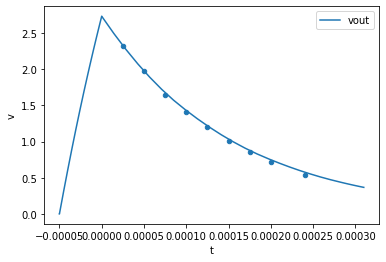

In [152]:
preamp_exp = pd.read_csv("dati/preamp_exp.txt", delimiter="\t")
ax=preamp_exp.plot(x='t',y='v', kind='scatter')
preamp_lin_sim=pd.read_csv("simulazioni/linearity_preamp.txt", delimiter="\t")
preamp_exp
preamp_lin_sim['t']=preamp_lin_sim['t']-50e-6
preamp_lin_sim.plot('t','vout',ax=ax)
# tensioni in Volt
# tempi in secondi 

Calcolo gli errori di digit (D), di scala (S) e totali (T).

In [154]:
preamp_exp['v_errD']= osc_dig*preamp_exp['v_scala']
preamp_exp['v_errS']= osc_scala*preamp_exp['v']
preamp_exp['v_errT']= ((preamp_exp['v_errD'])**2 + (preamp_exp['v_errS'])**2)**0.5
preamp_exp['v%']=preamp_exp['v_errT']/preamp_exp['v']*100
preamp_exp['t_err']=preamp_exp['t_div']*osc_t_err
preamp_exp['t%']=preamp_exp['t_err']/preamp_exp['t']*100
preamp_exp

,t,v,v_scala,t_div,v_errD,v_errS,v_errT,v%,t_err,t%
0,0.000025,2.3260,5,0.00001,0.022656,0.040472,0.046382,1.994081,4.000000e-07,1.600000
1,0.000050,1.9720,5,0.00001,0.022656,0.034313,0.041118,2.085081,4.000000e-07,0.798403
2,0.000075,1.6430,2,0.00001,0.009062,0.028588,0.029990,1.825334,4.000000e-07,0.533333
3,0.000100,1.4030,2,0.00001,0.009062,0.024412,0.026040,1.856027,4.000000e-07,0.399600
4,0.000125,1.2010,2,0.00001,0.009062,0.020897,0.022778,1.896573,4.000000e-07,0.319744
5,0.000150,1.0110,2,0.00001,0.009062,0.017591,0.019789,1.957323,4.000000e-07,0.266312
6,0.000175,0.8597,1,0.00001,0.004531,0.014959,0.015630,1.818078,4.000000e-07,0.228311
7,0.000200,0.7206,1,0.00001,0.004531,0.012538,0.013332,1.850138,4.000000e-07,0.200000
8,0.000240,0.5436,1,0.00001,0.004531,0.009459,0.010488,1.929359,4.000000e-07,0.166320


Faccio il fit esponenziale assumendo trascurabili gli errori sulle x.
Faccio il fit lineare dopo aver normalizzato le y

c 6395.3757448144515 460.81477768057226
tau_exp 0.00015636297848657725 1.1266636088925329e-05
a -0.04997238457355499 0.07884616376412378 -0.633796017305958
b 2.7705660042321223 0.001321664734234328
chisq 1.0472793874621884
sigmaP 0.01264652874530804
tau_lin 0.14955589013327503 0.001370894736245793
bth 3.205897535165828 0.09869063424778067
comp b 4.41067688038002
vin 0.01952142788820531
-----lineare----
m -6686.463496080705 61.29105047422816
q 1.0166251580672616 0.008984585785019436
chisq 4.025194988948319
sigmap 0.00863237473043123


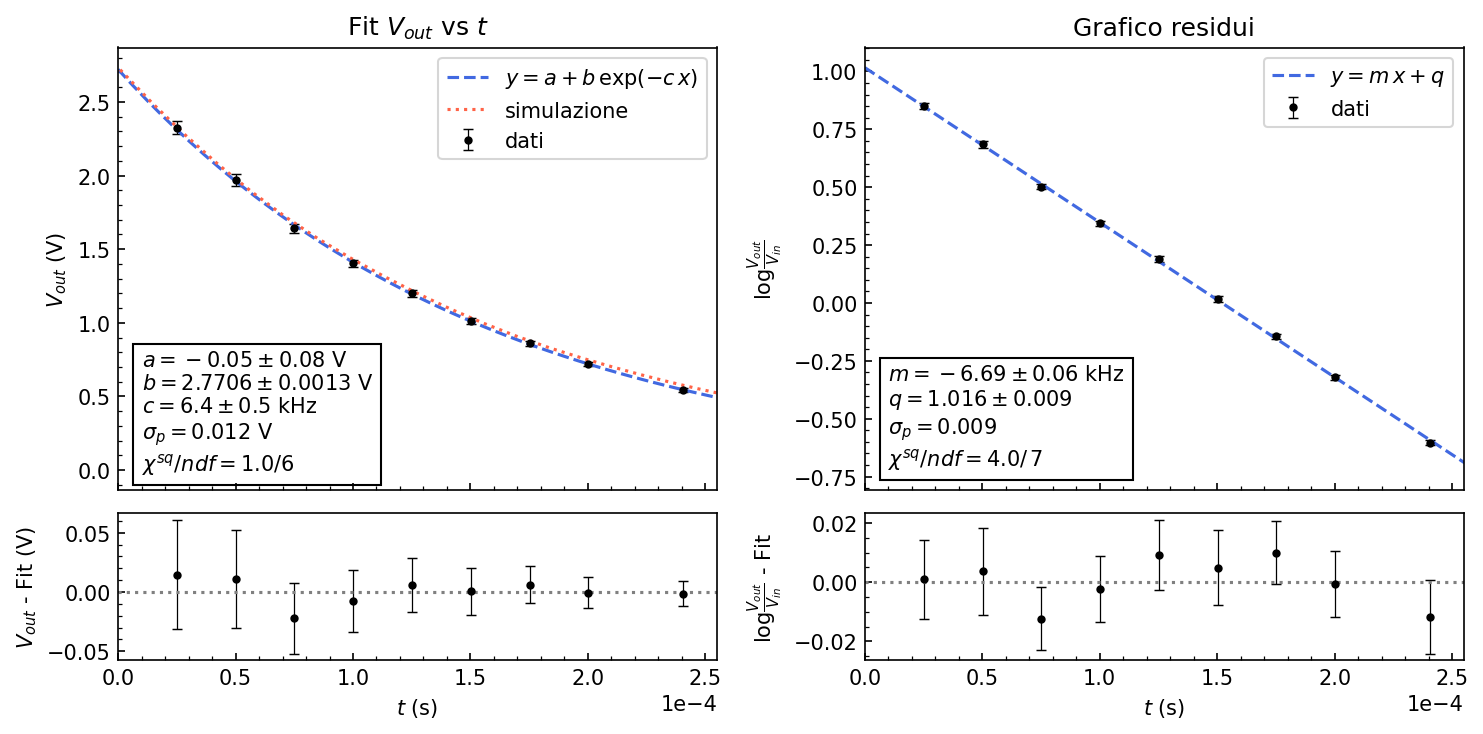

In [202]:
# funzione per fit esponenziale
def expF(X,a,b,c):
    return a+b*np.exp(-X*c)

# fit exp
X=preamp_exp['t']
Y=preamp_exp['v']
errY=preamp_exp['v_errT']
par,cov=curve_fit(expF,X,Y, sigma=errY,absolute_sigma=True)

# plot dati+fit +sim
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(10,5), gridspec_kw=dict(height_ratios=[3,1]), sharex=True)
fig.set_dpi(150)
axes[0][0].errorbar(X,Y,errY, fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[0][0].plot(np.linspace(0,0.0003), expF(np.linspace(0,0.0003),*par),
                "--",color='royalblue')
Xsim=preamp_lin_sim['t']
Ysim=preamp_lin_sim['vout']
axes[0][0].plot(Xsim,Ysim,':',color='tomato')
diff=Y-expF(X,*par)

# chisq e sigma post
sigmap = (np.sum(diff**2)/(len(diff)-3))**0.5
chisq = np.sum(diff**2/errY**2)


# plot residui
axes[1][0].errorbar(X,diff, errY, fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1][0].plot(np.linspace(0,0.0003),np.linspace(0,0), ":", color='gray')

# salvo i parametri
a=par[0]
a_err=cov[0][0]**0.5
b=par[1]
b_err=cov[1][1]*0.5
c=par[2]
c_err=cov[2][2]**0.5
print("c",c, c_err)
print("tau_exp",1/c, c_err/c**2)
print("a",a,a_err, a/a_err)
print("b",b,b_err)
print("chisq",chisq)
print("sigmaP",sigmap)


# fit lineare
Vint=-0.9937 # Volt, scala 2 V
Vint_e=(osc_dig*2)
H= abs(Y/Vint)
errH=H*((preamp_exp['v_errD']/Y)**2+(Vint_e/Vint)**2)**0.5
errYN=errH/H
Y=np.log(H)
parL,covL=curve_fit(linF,X,Y, sigma=errYN, absolute_sigma=True)
diff=Y-linF(X,*parL)
# chisq e sigma post
sigmapL = (np.sum(diff**2)/(len(diff)-2))**0.5
chisqL = np.sum(diff**2/errYN**2)

# plot fit lienare
axes[0][1].errorbar(X,Y,errYN, fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[0][1].plot(np.linspace(0,0.00026),linF(np.linspace(0,0.00026),*parL),
                '--',color='royalblue')
axes[1][1].errorbar(X,diff,errYN,fmt='.',color='black', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1][1].plot(np.linspace(0,0.00026),np.linspace(0,0),':',color='gray')
print("tau_lin",-1/parL[0]*1000, covL[0][0]**0.5/abs(parL[0])**2*1000)
# print(errYN/Y)


# plot customization
xmin=0
xmax=0.000255
axes[1][0].set_xlabel("$t$ (s)")
axes[1][1].set_xlabel("$t$ (s)")
axes[0][0].set_ylabel("$V_{out}$ (V)")
axes[1][0].set_ylabel("$V_{out}$ - Fit (V)")

axes[0][1].set_ylabel(r"$\log{\frac{V_{out}}{V_{in}}}$")
axes[1][1].set_ylabel(r"$\log{\frac{V_{out}}{V_{in}}}$ - Fit")

axes[0][0].set_title("Fit $V_{out}$ vs $t$ ")
axes[0][1].set_title("Grafico residui")

axes[0][0].legend(labels=('$y=a+b\,\exp{(-c\,x)}$','simulazione', 'dati'))
axes[0][1].legend(labels=('$y=m\,x+q$', 'dati'))

axes[0][0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
for j in axes:
    for i in j:
        i.set_xlim(xmin,xmax)
        i.tick_params(axis='both', which='minor', direction='in')
        i.tick_params(axis='both', which='major', direction='in')
        i.minorticks_on()

# box
axes[0][0].text(0.00001, 0.00032, '$a=-0.05\pm 0.08$ V'
                                  '\n$b=2.7706 \pm 0.0013$ V'
                                  '\n$c=6.4 \pm 0.5$ kHz'
                                  '\n$\sigma_p=0.012$ V'
                                  '\n$\chi^{sq}/ndf=1.0/6$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=4.0))

axes[0][1].text(0.00001, -0.70, '$m=-6.69\pm 0.06$ kHz'
                                  '\n$q=1.016 \pm 0.009$'
                                  '\n$\sigma_p=0.009$'
                                  '\n$\chi^{sq}/ndf=4.0/\,7$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', pad=4.0))



fig.tight_layout()
fig.savefig("../../latex/preamp/images/fit_exp_lin.png", dpi=200)

Vin=-0.9937
Vin_scala=2
Vin_e=((Vin_scala*osc_dig)**2+(Vin*osc_scala)**2)**0.5
bth=-Vin/(Rin*1e3)*50e-6/(Cf_pre*1e-9)
bth_e=abs(bth)*((Vin_e/Vin)**2+(Rin_err/Rin)**2+(Cf_pre_err/Cf_pre)**2)**0.5
print("bth",bth,bth_e )
print("comp b",(bth-b)/(bth_e**2+b_err**2)**0.5 )
print("vin",Vin_e)
print("-----lineare----")
print("m",parL[0],covL[0][0]**0.5)
print("q", parL[1],covL[1][1]**0.5)
print("chisq",chisqL)
print("sigmap",sigmapL)

## Bode

Importo i dati 

In [30]:
preamp_bode=pd.read_csv("dati/preamp_bode.txt", delimiter='\t')
bode_sim=pd.read_csv("simulazioni/sim_bode_preamp.txt",delimiter="\t")
preamp_bode
# frequenze in Hertz
# tensioni in Volt

,f,Vin,Vin_s,Vout,Vout_s
0,100.0,0.9836,2,9.79800,10.0
1,165.0,0.9836,2,9.73500,10.0
2,270.0,0.9836,2,9.52000,10.0
3,440.0,0.9836,2,9.06400,10.0
4,720.0,0.9836,2,8.12900,10.0
5,1180.0,0.9836,2,6.51100,10.0
6,1930.0,0.9735,2,4.68400,5.0
7,3160.0,0.9735,2,3.07800,5.0
8,5180.0,0.9735,2,1.94900,2.0
9,8480.0,0.9735,2,1.20100,2.0


Calcolo gli errori tenendo presente che nel fit mi serve solo la parte casuale. L'errore di scala viene infatti 
scaricato sull'intercetta una volta preso il logaritmo 

In [31]:
# errori tensioni
preamp_bode['Vout_err']= osc_dig*preamp_bode['Vout_s']
preamp_bode['Vin_err']= osc_dig*preamp_bode['Vin_s']

# funzione di trasferimento 
preamp_bode['H']=preamp_bode['Vout']/preamp_bode['Vin']
preamp_bode['Hdb']=20*np.log10(preamp_bode['H'])

# errore funzione di trasferimento
preamp_bode['H_err']=preamp_bode['H']*( 
    (preamp_bode['Vin_err']/preamp_bode['Vin'])**2 +
    (preamp_bode['Vout_err']/preamp_bode['Vout'])**2 )**0.5
preamp_bode['Hdb_err']=20./preamp_bode['H']*np.log10(math.e)*preamp_bode['H_err']
preamp_bode

,f,Vin,Vin_s,Vout,Vout_s,Vout_err,Vin_err,H,Hdb,H_err,Hdb_err
0,100.0,0.9836,2,9.79800,10.0,0.045312,0.009062,9.961366,19.966378,0.102693,0.089544
1,165.0,0.9836,2,9.73500,10.0,0.045312,0.009062,9.897316,19.910349,0.102166,0.089661
2,270.0,0.9836,2,9.52000,10.0,0.045312,0.009062,9.678731,19.716369,0.100372,0.090076
3,440.0,0.9836,2,9.06400,10.0,0.045312,0.009062,9.215128,19.290028,0.096597,0.091050
4,720.0,0.9836,2,8.12900,10.0,0.045312,0.009062,8.264538,18.344372,0.088997,0.093535
5,1180.0,0.9836,2,6.51100,10.0,0.045312,0.009062,6.619561,16.416584,0.076433,0.100292
6,1930.0,0.9735,2,4.68400,5.0,0.022656,0.009062,4.811505,13.645619,0.050477,0.091122
7,3160.0,0.9735,2,3.07800,5.0,0.022656,0.009062,3.161787,9.998653,0.037523,0.103081
8,5180.0,0.9735,2,1.94900,2.0,0.009062,0.009062,2.002054,6.029518,0.020833,0.090384
9,8480.0,0.9735,2,1.20100,2.0,0.009062,0.009062,1.233693,1.824141,0.014784,0.104086


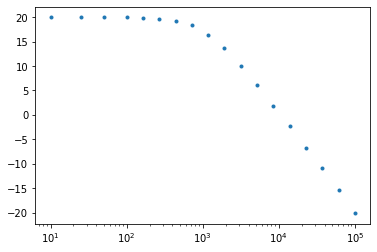

In [32]:
# faccio plot esplorativo grafico di bode
X=preamp_bode['f']
Y=preamp_bode['Hdb']
errY=preamp_bode['Hdb_err']
ax=plt.errorbar(X,Y,errY,fmt='.')
plt.xscale('log')

Individuo il range di misure per il primo fit lineare e il range di misure per il secondo fit lineare.
L'intersezione delle due interpolazioni restituisce la frequenza di taglio del circuito.

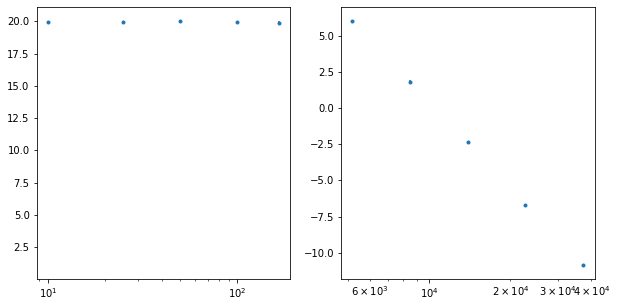

In [262]:
flim1=250
X1=preamp_bode['f'][preamp_bode['f']< flim1]
Y1=preamp_bode['Hdb'][preamp_bode['f']<flim1]
errY1=preamp_bode['Hdb_err'][preamp_bode['f']<flim1]

flim2=4000
fsup2=5e4
X2=preamp_bode['f'][preamp_bode['f']> flim2][preamp_bode['f']< fsup2]
Y2=preamp_bode['Hdb'][preamp_bode['f']>flim2][preamp_bode['f']< fsup2]
errY2=preamp_bode['Hdb_err'][preamp_bode['f'] > flim2][preamp_bode['f']< fsup2]

fig,axes=plt.subplots(ncols=2,figsize=(10,5))
axes[0].errorbar(X1,Y1, errY1,fmt='.')
axes[0].semilogx(True)
axes[1].errorbar(X2,Y2,errY2,fmt='.')
axes[1].semilogx(True)

Faccio i due fit e li mostro nel grafico di Bode

m1 -0.006884307757144936 0.09281309783047162
q1 19.975138359235856 0.15944351501660245
m2 -19.749730036828485 0.14472758447130898
q2 79.40208758286992 0.5984036173723929
cov(m1,q1) -0.014324038715216146
cov(m2,q2) -0.08637524046364164
chisq12 1.4873830906386858 1.0649870211993249
sigmap12 0.04123080128628093 0.03704039578863457


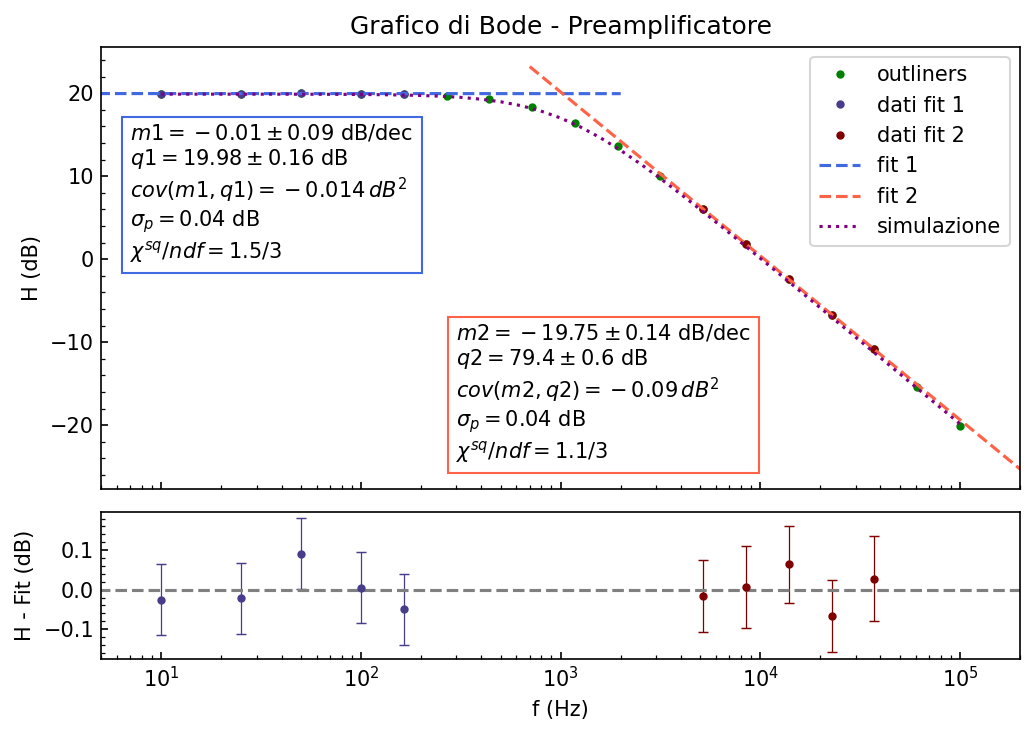

In [284]:
# creo plot
fig,axes=plt.subplots(nrows=2,sharex=True,figsize=(7,5), gridspec_kw=dict(height_ratios=[3,1]))
fig.set_dpi(150)
# fit
par1,cov1=curve_fit(linF,np.log10(X1),Y1,sigma=errY1,absolute_sigma=True)
par2,cov2=curve_fit(linF,np.log10(X2),Y2,sigma=errY2,absolute_sigma=True)
diff1=Y1-linF(np.log10(X1),*par1)
diff2=Y2-linF(np.log10(X2),*par2)

# chisq e sigma post
sigmap1 = (np.sum(diff1**2)/(len(diff)-2))**0.5
chisq1 = np.sum(diff1**2/errY1**2)
sigmap2 = (np.sum(diff2**2)/(len(diff)-2))**0.5
chisq2 = np.sum(diff2**2/errY2**2)

# plot dati+sim+fit
axes[0].plot(preamp_bode['f'],preamp_bode['Hdb'], '.',label="outliners",color='green')
axes[0].plot(X1,Y1,'.',color='darkslateblue',label='dati fit 1')
axes[0].plot(X2,Y2,'.',color='maroon', label='dati fit 2')
axes[0].plot(np.linspace(0,2e3), linF(np.log10(np.linspace(2e1,1e3)),*par1),'--',color='royalblue',
            label='fit 1')
axes[0].plot(np.linspace(7e2,2e5), linF(np.log10(np.linspace(7e2,2e5)),*par2),'--',color='tomato', 
            label="fit 2")
axes[0].plot(bode_sim['f'],bode_sim['V'],':', color='purple', label='simulazione')

# plot residui
axes[1].errorbar(X1,diff1,errY1,fmt='.', color='darkslateblue', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1].errorbar(X2,diff2,errY2,fmt='.', color='maroon', capsize=2.5,
                 capthick=0.7, elinewidth=0.6)
axes[1].plot(np.linspace(0,3e5),np.linspace(0,0), '--',color='gray')

axes[0].semilogx(True)
axes[0].legend()

# plot customization
xmin=5
xmax=2e5
axes[1].set_xlabel("f (Hz)")
axes[0].set_ylabel("H (dB)")
axes[1].set_ylabel("H - Fit (dB)")

axes[0].set_title("Grafico di Bode - Preamplificatore")

#axes[0][0].legend(labels=('$y=a+b\,\exp{(-c\,x)}$','simulazione', 'dati'))
#axes[0][1].legend(labels=('$y=m\,x+q$', 'dati'))

#axes[0][0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
for i in axes:
    i.set_xlim(xmin,xmax)
    i.tick_params(axis='both', which='minor', direction='in')
    i.tick_params(axis='both', which='major', direction='in')
    i.minorticks_on()

# box
axes[0].text(7,0.1, '$m1=-0.01\pm 0.09$ dB/dec'
                               '\n$q1=19.98 \pm 0.16$ dB'
                               '\n$cov(m1,q1)=-0.014\,dB^2$'
                                '\n$\sigma_p=0.04$ dB'
                                '\n$\chi^{sq}/ndf=1.5/3$', color='black', 
       bbox=dict(facecolor='none', edgecolor='royalblue', pad=4))

axes[0].text(300,-24, '$m2=-19.75\pm 0.14$ dB/dec'
                               '\n$q2=79.4 \pm 0.6$ dB'
                               '\n$cov(m2,q2)=-0.09\,dB^2$'
                                '\n$\sigma_p=0.04$ dB'
                                '\n$\chi^{sq}/ndf=1.1/3$', color='black', 
       bbox=dict(facecolor='none', edgecolor='tomato', pad=4))


fig.tight_layout()
fig.savefig("../../latex/preamp/images/fit_bode.png", dpi=150)

m1=par1[0]
m1_e=cov1[0][0]**0.5
q1=par1[1]
q1_e=cov1[1][1]**0.5
covmq1=cov1[0][1]

m2=par2[0]
m2_e=cov2[0][0]**0.5
q2=par2[1]
q2_e=cov2[1][1]**0.5
covmq2=cov2[0][1]

print("m1",m1,m1_e)
print("q1",q1,q1_e)
print("m2",m2,m2_e)
print("q2",q2,q2_e)
print("cov(m1,q1)",covmq1)
print("cov(m2,q2)",covmq2)
print("chisq12",chisq1,chisq2)
print("sigmap12",sigmap1,sigmap2)

Stimo frequenza di taglio da intersezione delle due rette

In [285]:
ft_int=(par2[1]-par1[1])/(par1[0]-par2[0])
ft_int_e=ft_int*( (q1_e**2+q2_e**2)/(q1-q2)**2 +
                  (m1_e**2+m2_e**2)/(m1-m2)**2 +
                  2*(covmq1+covmq2)/((q1-q2)*(m2-m1)) )**0.5
ft_int_lin=10**ft_int
ft_int_lin_e=ft_int_lin*np.log(10)*ft_int_e
print(ft_int_lin,ft_int_lin_e )
ft_int_e

1023.410384726716 25.35307013381897


0.010758830106422979